# Lets figure out GIS

## Todo

- [ ] Get property boundaries loaded
- [ ] Get planning layers loaded
- [ ] Get heritage overlays loaded
- [ ] Delete earlier notebook

# Scrapping

Here I'm testing different configurations for scrapping.

## Different APIs to test

- [NSW Spatial][portal-nsw-spatial] `https://portal.spatial.nsw.gov.au`
  - **NSW Property feature layer**: this is of interest because it has NSW property id which can be used to link against the value general stuff.
  - **NSW Lot feature layer**: This is interesting as it has lot numbers.
- [Environment NSW][portal-nsw-environment]

[portal-nsw-environment]: https://mapprod3.environment.nsw.gov.au/arcgis/rest/services/Planning/EPI_Primary_Planning_Layers/MapServer
[portal-nsw-spatial]: https://portal.spatial.nsw.gov.au/server/rest/services/NSW_Land_Parcel_Property_Theme/FeatureServer

## Request Times

- Querying NSW Address field
  - Filtering by `lastupdated` field
    - Jan 2023 to Jun 2024, 0h 3m 55s
    - Jan 2020 to Oct 2024, 0h 10m 39s 
    - Jan 2010 to Oct 2024, **4**h **16**m **29**s (`2410766` items)
      - Interestingly when I saw the finished result the last result was `April 2013`. At the time I thought that was the earlier it went back, but I think that must have been a timeframe with some of the most updates.
    - Feb 2013 to Apr 2013, **36**m **40**s (12 concurrent workers)
      - I checked this to see `April 2013` is really the last period
      - The first 2 months takes **2**m **27**s to run @ `25703` items
      - There must be a lot of stuff here
    - Jan 1990 to Feb 2013
      - `143600` items in it's at **35**m **24**s
      - got to `290100` items at **1**h **17**m **55**s and crashed on `2008-04-01`
    - Apr 2008 to May 2008
      - got to `249574` items at **1**h **1**m **4**s, still going
      - got to `422941` items at **1**h **53**m **42**s, then crashed

2024-09-20 17:54:03 #47: 4667 items via @ 0h 0m 41s
https://portal.spatial.nsw.gov.au/server/rest/services/NSW_Land_Parcel_Property_Theme/FeatureServer/12
(2200/14336) 15% progress for lastupdate >= DATE '2011-4-1' AND lastupdate < DATE '2011-5-1'


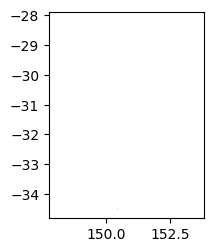

,RID,propid,principaladdresssiteoid,addressstringoid,propertytype,superlot,housenumber,address,principaladdresstype,createdate,startdate,enddate,lastupdate,shapeuuid,changetype,Shape__Length,Shape__Area,geometry
0,801020,1123593,657543,2439187,1,N,10,10 THOMPSON STREET BOWRAL,1,1303430164000,1303721641000,32503680000000,1303721716473,d045f1f3-54bc-3245-ae60-dfbd86df7449,M,174.126452,1582.579855,"POLYGON ((150.43062 -34.49232, 150.43053 -34.4..."


In [ ]:
from aiohttp import ClientSession
from datetime import datetime
import geopandas as gpd
from IPython.display import clear_output
import math
import matplotlib.pyplot as plt
import time

from lib.debug import NotebookTimer
from lib.gis.defaults import HOST_SEMAPHORE_CONFIG as t_conf
from lib.gis.defaults import ENSW_DA_PROJECTION
from lib.gis.defaults import SNSW_LOT_PROJECTION
from lib.gis.defaults import SNSW_PROP_PROJECTION
from lib.gis.defaults import ENSW_ZONE_PROJECTION

from lib.gis.producer import GisProducer
from lib.service.http.exp_backoff import BackoffConfig, RetryPreference
from lib.service.http import CachedClientSession, ThrottledSession, ExpBackoffClientSession

backoff_config = BackoffConfig(RetryPreference(allowed=8))

try:
    timer_state = { 'count': 0, 'items': 0 }
    timer = NotebookTimer('#%(count)s: %(items)s items via', timer_state)

    # This http client composes a cache layer and a throttling
    # layer. Some GIS serves, such as the ones below may end
    # up blocking you if you perform to much traffic at once.
    # 
    #   - Caching ensure requests that do not need to be
    #     repeated, are not repeated.
    #
    #   - Expotenial backoff is here to retry when in the
    #     the event any requests to the GIS server fail.
    #
    #   - Throttling of course ensure we do not have more
    #     active requests to one host at a time. The max
    #     active requests is set on a host basis.
    #
    throttle_s = ThrottledSession.create(t_conf)
    ebackoff_s = ExpBackoffClientSession.create(backoff_config, throttle_s)
    
    async with CachedClientSession.create(ebackoff_s) as session:
        producer = GisProducer(session)
        producer.queue(SNSW_PROP_PROJECTION)
        producer.queue(SNSW_LOT_PROJECTION)
        # reader.queue(ENSW_ZONE_PROJECTION)
        # reader.queue(ENSW_DA_PROJECTION)
        
        async for proj, task, page in producer.produce([]):
            clear_output(wait=True)
            timer.add({ 'items': len(page), 'count': 1 })
            timer.log()
            print(proj.schema.url)
            print(producer.progress(proj, task))
            if len(page) > 0:
                fig, ax = plt.subplots(1, 1, figsize=(2, 4))
                page.plot(ax=ax, column=proj.schema.debug_plot_column)
                plt.show()
                display(page.iloc[:1])
                
        print(f"finished loading GIS'")
except Exception as e:
    raise e